* https://www.kaggle.com/ntnu-testimon/paysim1

In [2]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.python.data import Dataset
import pickle

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#for logistic regression and over sampling
#cc = !nproc
cc = !sysctl -n hw.ncpu
cc = int(cc[0])

%matplotlib inline

In [3]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [4]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [5]:
data.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.6,C1231006815,170136.0,160296.4,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.3,C1666544295,21249.0,19384.7,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.1,C2048537720,41554.0,29885.9,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15,1,CASH_OUT,229133.9,C905080434,15325.0,0.0,C476402209,5083.0,51513.4,0,0
16,1,PAYMENT,1563.8,C761750706,450.0,0.0,M1731217984,0.0,0.0,0,0
17,1,PAYMENT,1157.9,C1237762639,21156.0,19998.1,M1877062907,0.0,0.0,0,0
18,1,PAYMENT,671.6,C2033524545,15123.0,14451.4,M473053293,0.0,0.0,0,0


In [6]:
data.shape

(6362620, 11)

Elapsed time is 1.8194818496704102 seconds.


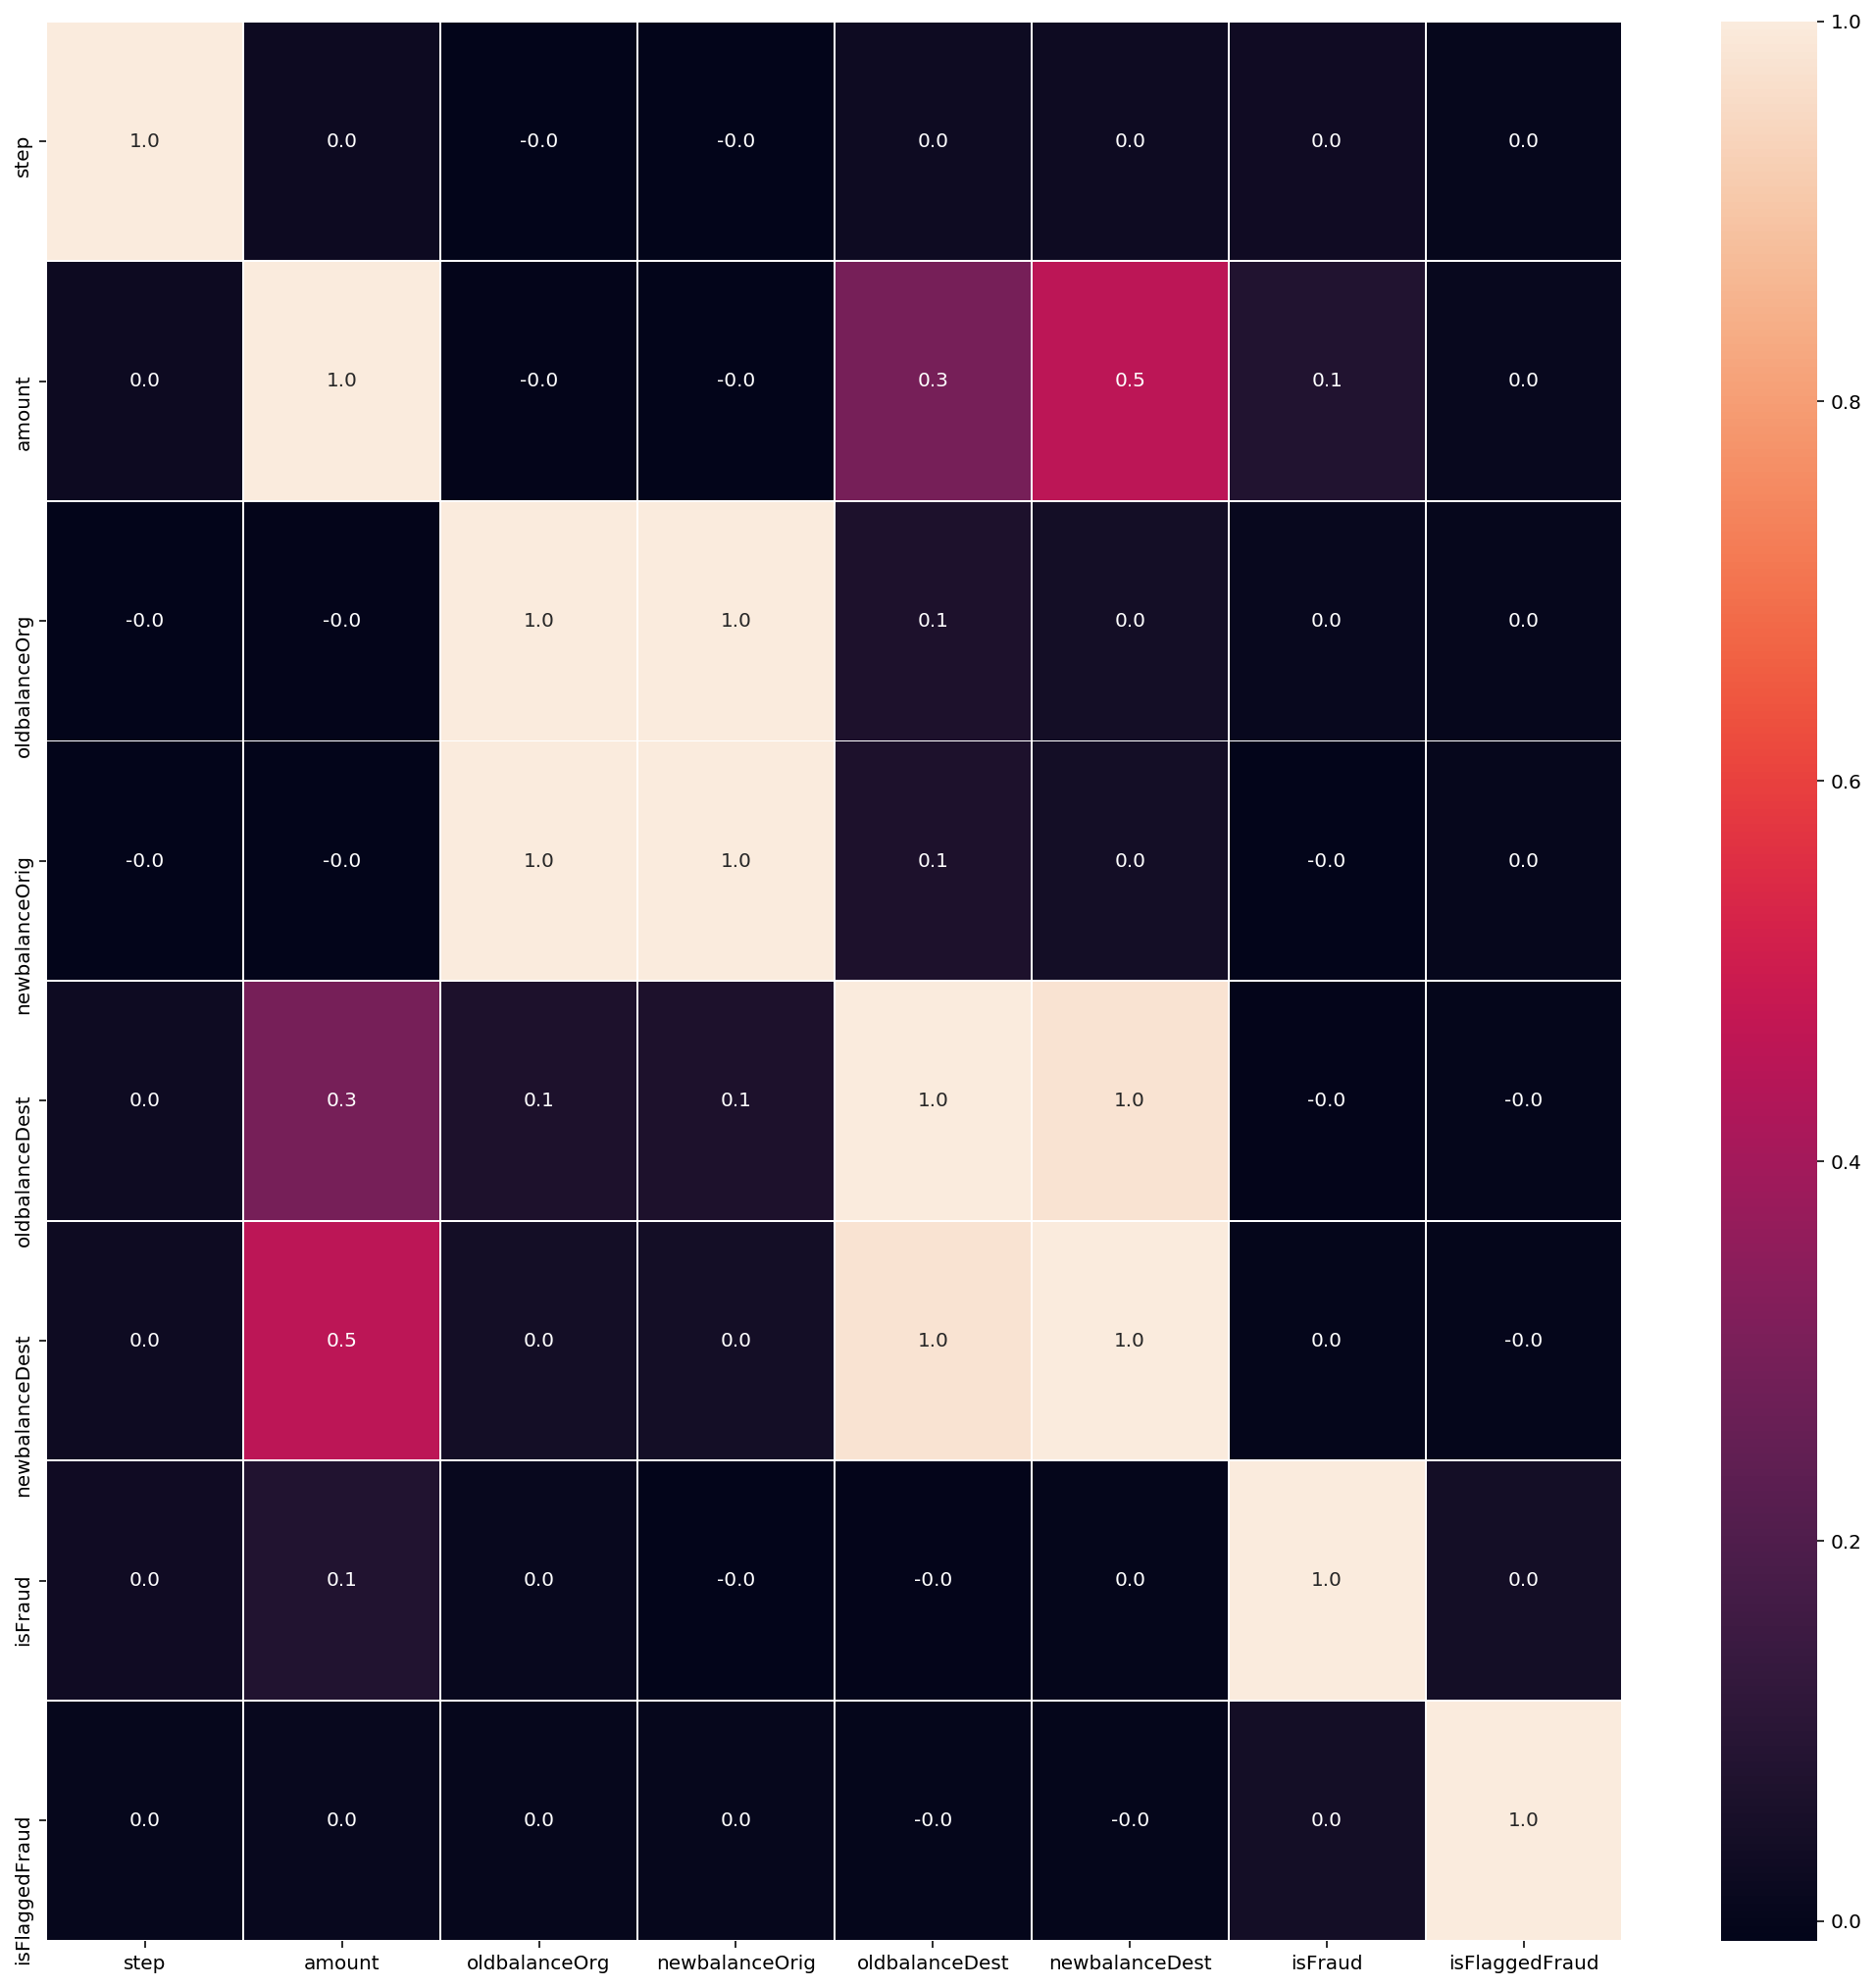

In [7]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

In [8]:
#look at class imbalance
by_class = data.groupby('isFraud')
by_class.describe()

step                                            amount            \
            count  mean   std min   25%   50%   75%   max     count      mean   
isFraud                                                                         
0       6354407.0 243.2 142.1 1.0 156.0 239.0 334.0 718.0 6354407.0  178197.0   
1          8213.0 368.4 216.4 1.0 181.0 367.0 558.0 743.0    8213.0 1467967.3   

         ... newbalanceDest             isFlaggedFraud                       \
         ...            75%         max          count mean std min 25% 50%   
isFraud  ...                                                                  
0        ...      1111975.3 356179278.9      6354407.0  0.0 0.0 0.0 0.0 0.0   
1        ...      1058725.2 236726494.7         8213.0  0.0 0.0 0.0 0.0 0.0   

                 
        75% max  
isFraud          
0       0.0 0.0  
1       0.0 1.0  

[2 rows x 56 columns]

In [9]:
#look at class imbalance
by_class = data.groupby('isFlaggedFraud')
by_class.describe()

step                                              amount  \
                   count  mean   std   min   25%   50%   75%   max     count   
isFlaggedFraud                                                                 
0              6362604.0 243.4 142.3   1.0 156.0 239.0 335.0 743.0 6362604.0   
1                   16.0 537.6 181.9 212.0 415.5 601.5 678.8 741.0      16.0   

                          ... newbalanceDest               isFraud           \
                    mean  ...            75%         max     count mean std   
isFlaggedFraud            ...                                                 
0               179850.1  ...      1111914.1 356179278.9 6362604.0  0.0 0.0   
1              4861597.7  ...            0.0         0.0      16.0  1.0 0.0   

                                    
               min 25% 50% 75% max  
isFlaggedFraud                      
0              0.0 0.0 0.0 0.0 1.0  
1              1.0 1.0 1.0 1.0 1.0  

[2 rows x 56 columns]

In [10]:
data.groupby('type')['isFraud','isFlaggedFraud'].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


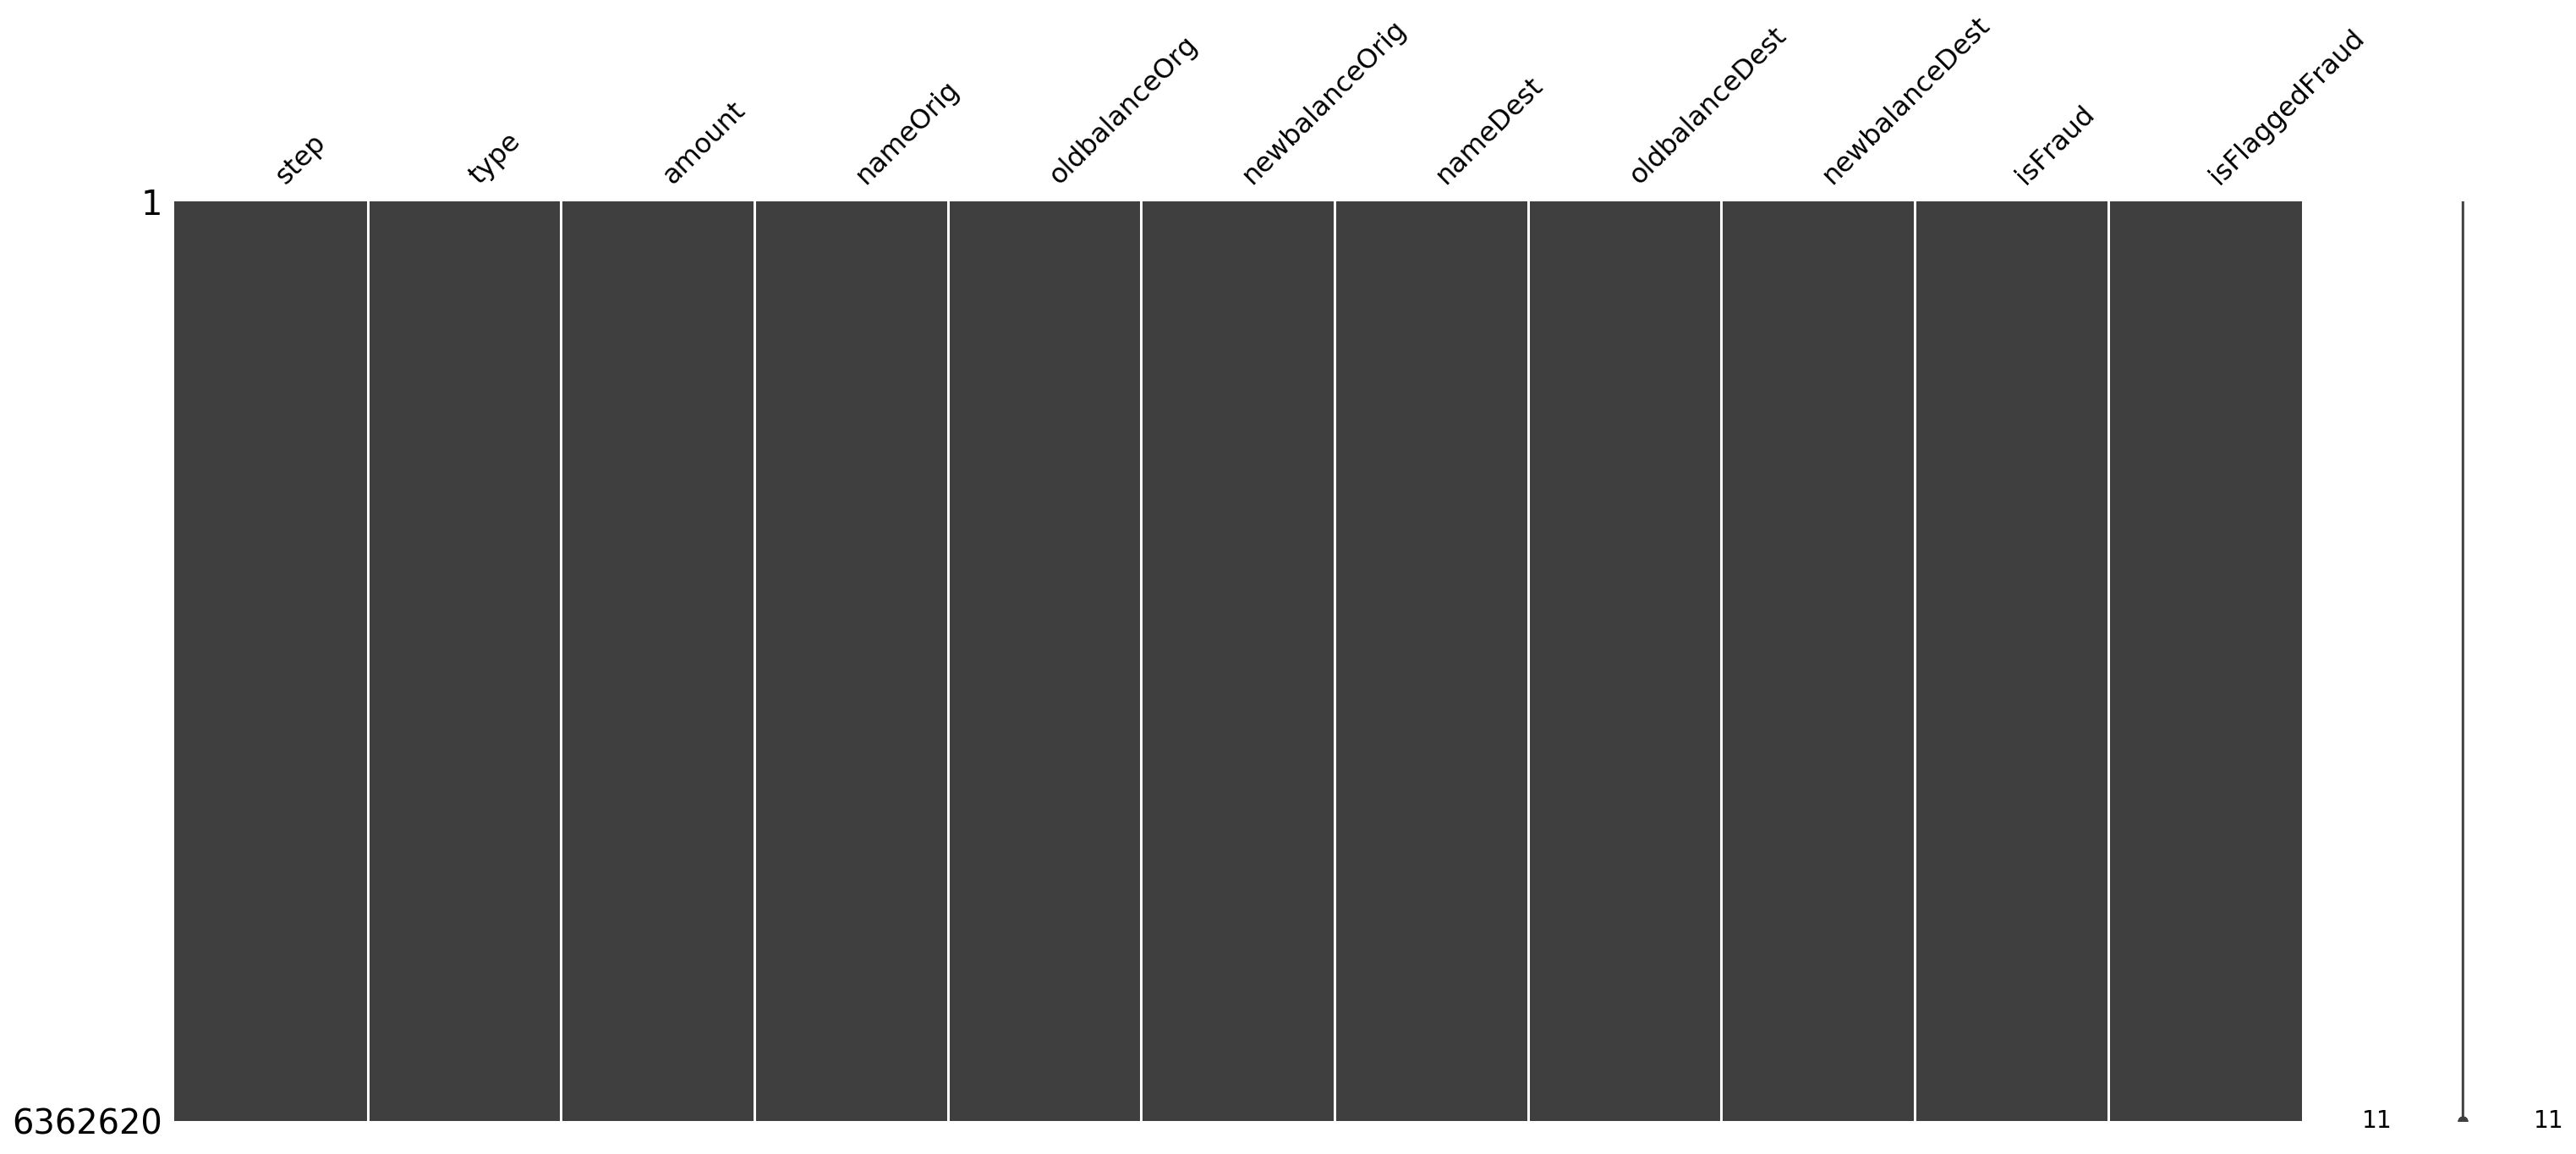

In [11]:
msno.matrix(data); # looks like no missing values

### Normalise the data

In [13]:
norm_step = np.array(data['step'])
norm_amount = np.array(data['amount'])
norm_newbalanceOrig = np.array(data['newbalanceOrig'])
norm_newbalanceDest = np.array(data['newbalanceDest'])

norm_step = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_amount = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_newbalanceOrig = StandardScaler().fit_transform(norm_newbalanceOrig.reshape(-1,1))
norm_newbalanceDest = StandardScaler().fit_transform(norm_newbalanceDest.reshape(-1,1))

/Users/scheckley/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/scheckley/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
data['norm_step'] = norm_step
data['norm_amount'] = norm_amount
data['norm_newbalanceOrig'] = norm_newbalanceOrig
data['norm_newbalanceDest'] = norm_newbalanceDest

In [15]:
# encode the transaction type
# http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
cols_to_transform = ['type']
type_hash = pd.get_dummies(data=data['type'])
#data['type_hash'] = type_hash

In [16]:
data = pd.concat([data, type_hash], axis=1)

In [17]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,norm_step,norm_amount,norm_newbalanceOrig,norm_newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.6,C1231006815,170136.0,160296.4,M1979787155,0.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
1,1,PAYMENT,1864.3,C1666544295,21249.0,19384.7,M2044282225,0.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,-1.7,-1.7,-0.3,-0.3,0,0,0,0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,-1.7,-1.7,-0.3,-0.3,0,1,0,0,0
4,1,PAYMENT,11668.1,C2048537720,41554.0,29885.9,M1230701703,0.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
5,1,PAYMENT,7817.7,C90045638,53860.0,46042.3,M573487274,0.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
6,1,PAYMENT,7107.8,C154988899,183195.0,176087.2,M408069119,0.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
7,1,PAYMENT,7861.6,C1912850431,176087.2,168225.6,M633326333,0.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
8,1,PAYMENT,4024.4,C1265012928,2671.0,0.0,M1176932104,0.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
9,1,DEBIT,5337.8,C712410124,41720.0,36382.2,C195600860,41898.0,40348.8,0,0,-1.7,-1.7,-0.3,-0.3,0,0,1,0,0


Elapsed time is 9.123272895812988 seconds.


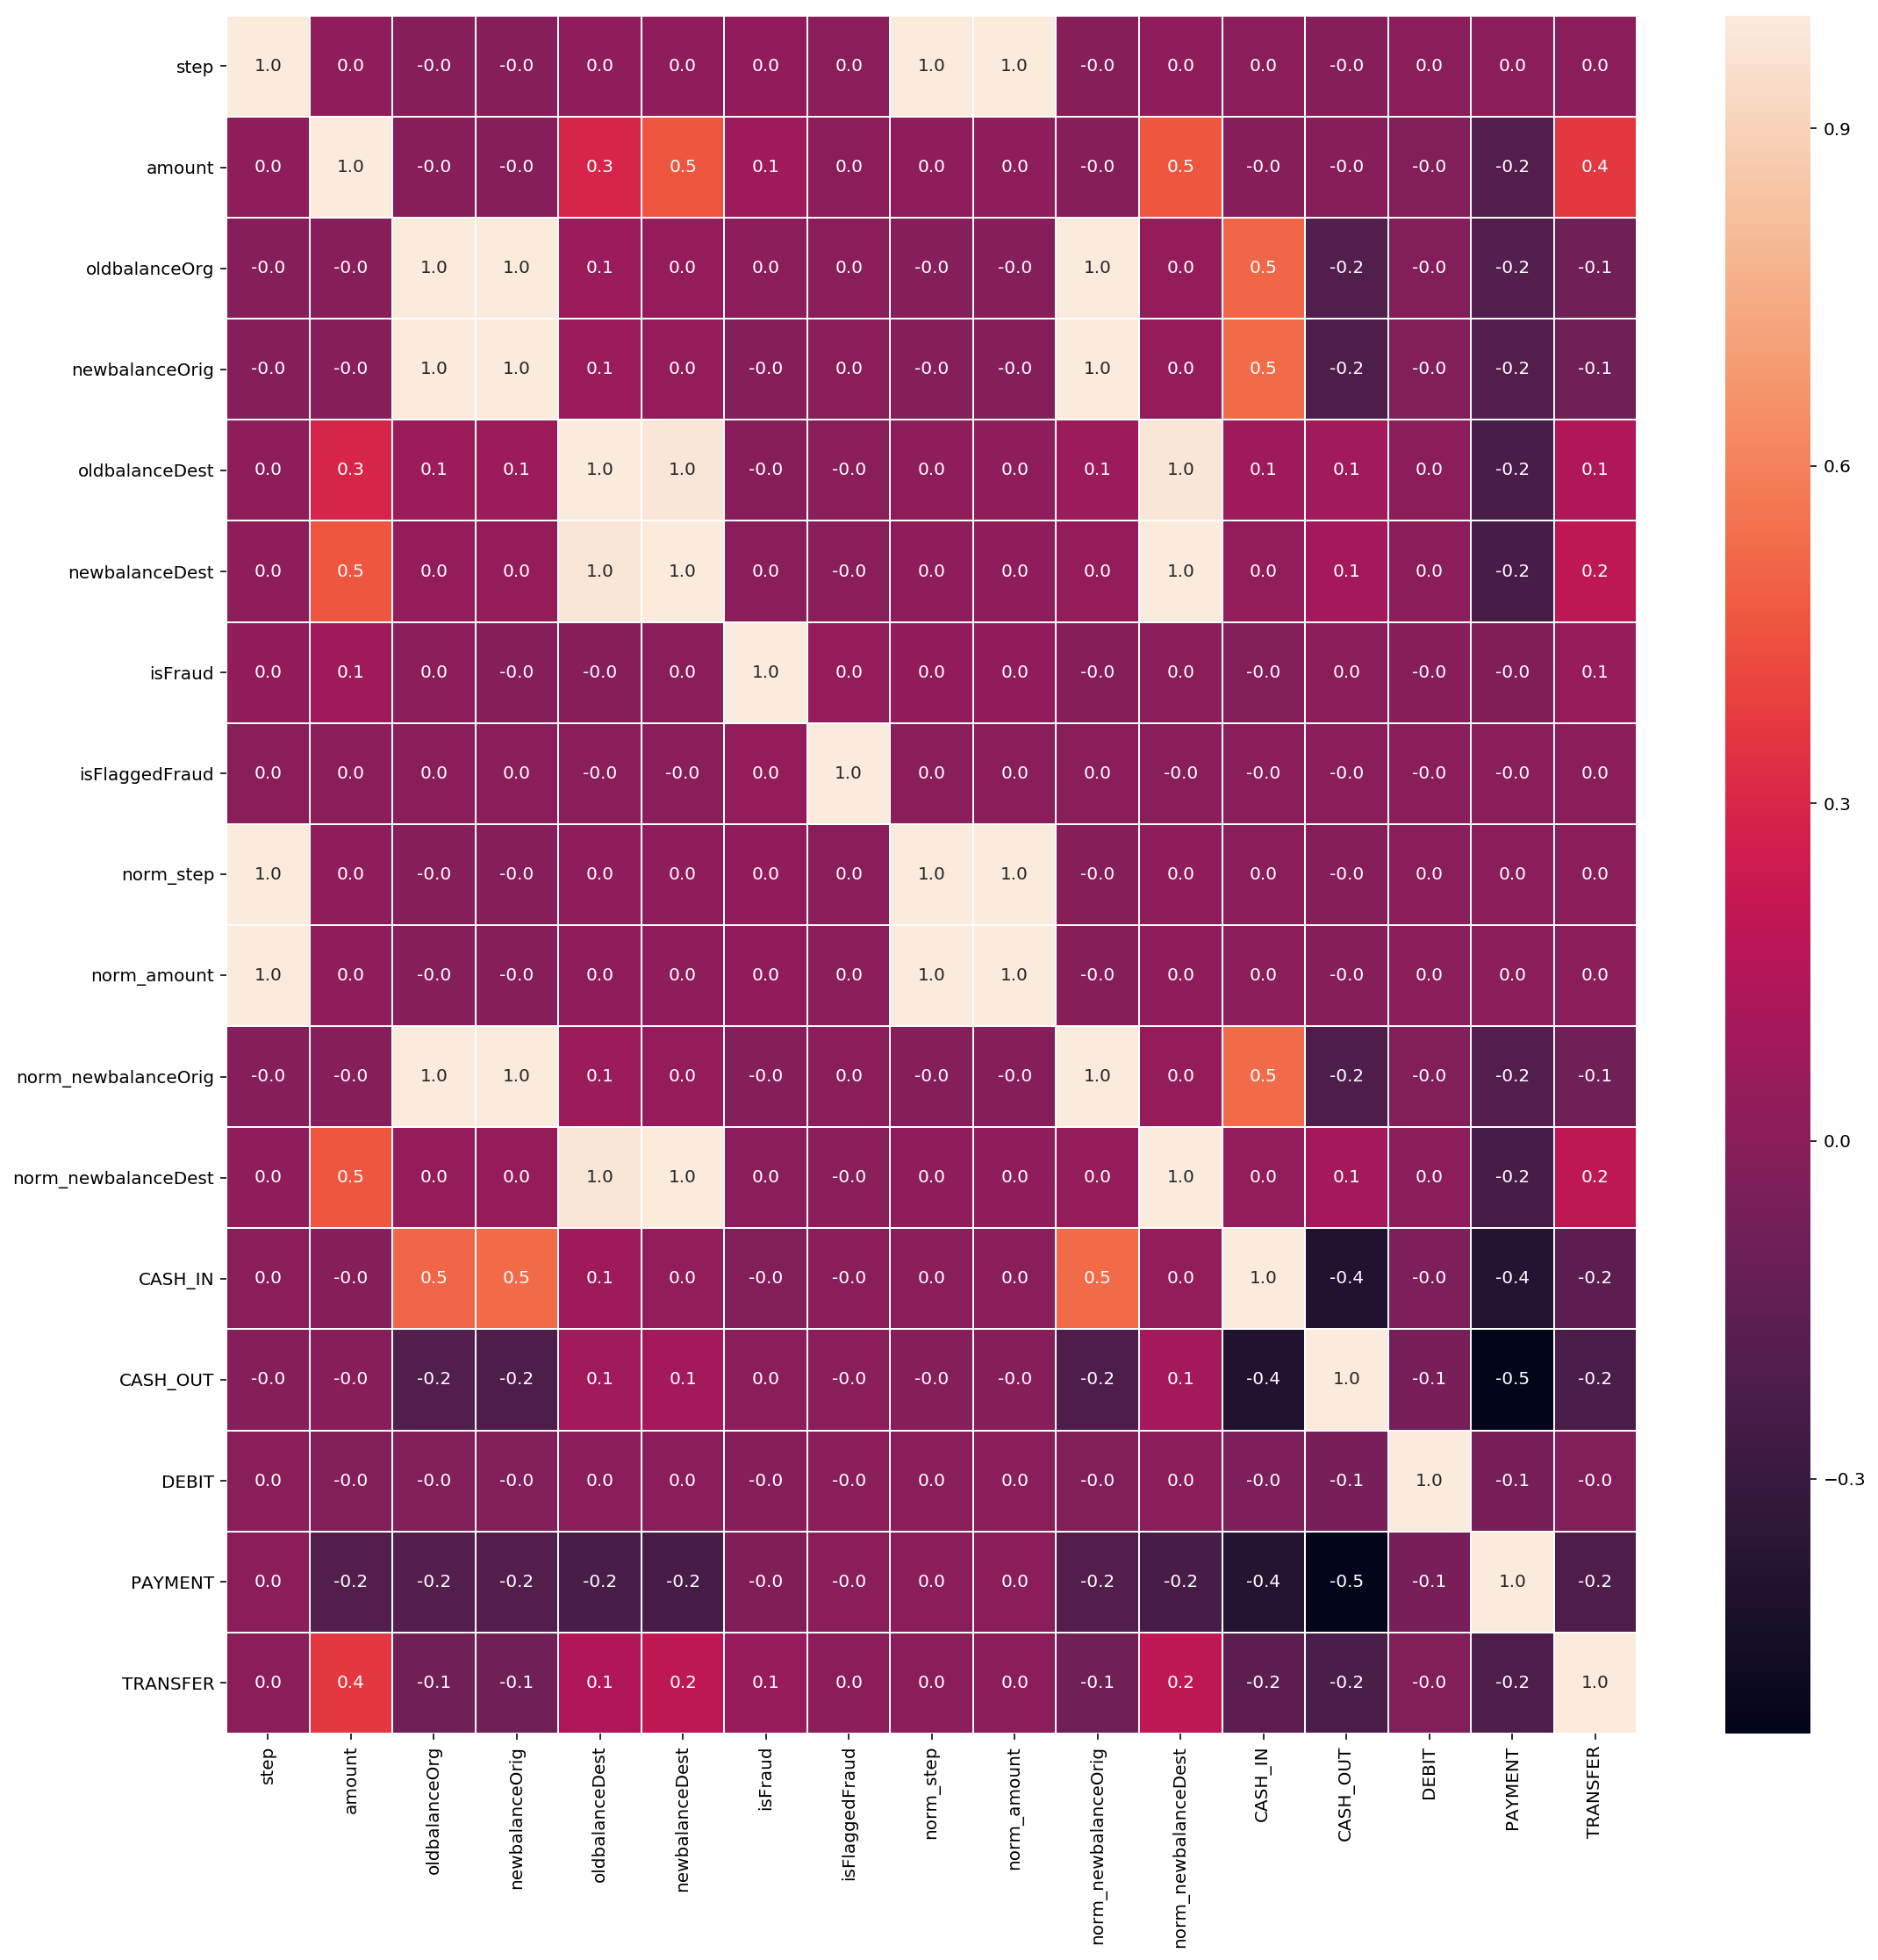

In [18]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

## Prepare the data for training

In [19]:
#randomize the data to be sure not to have any pathological ordering effects that might impact on gradient descent.
data = data.reindex(
    np.random.permutation(data.index))

In [20]:
#pickle.dump(data, open( "processed_data.pkl", "wb" ))

In [21]:
#data = pickle.load(open( "processed_data.pkl", "rb" ))
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'norm_step', 'norm_amount', 'norm_newbalanceOrig',
       'norm_newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER'],
      dtype='object')

In [22]:
def preprocess_features(data):
  """
  Args:
    data: A Pandas DataFrame expected to contain data
      from the kaggle data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = data[
    ["norm_step",
     "CASH_IN",
     "CASH_OUT",
     "DEBIT",
     "PAYMENT",
     "TRANSFER",
     "norm_amount",
     "norm_newbalanceOrig",
     "norm_newbalanceDest"]]
  processed_features = selected_features.copy()

  return processed_features

def preprocess_targets(data):
  """Prepares target features (i.e., labels) from kaggle data set.

  Args:
    data: A Pandas DataFrame expected to contain data
      from the kaggle data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["isFraud"] = (
    data["isFraud"])
  return output_targets

In [23]:
num_training = int(70/100*len(data))
num_validation = int(len(data) - num_training)

print("length of dataframe =",len(data), "|", "training set =", num_training, "|", "num_validation =", num_validation)

length of dataframe = 6362620 | training set = 4453834 | num_validation = 1908786


In [24]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(data.head(50000))
training_targets = preprocess_targets(data.head(50000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(data.tail(50000))
validation_targets = preprocess_targets(data.tail(50000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,norm_step,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,norm_amount,norm_newbalanceOrig,norm_newbalanceDest
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0
mean,-0.0,0.2,0.4,0.0,0.3,0.1,-0.0,0.0,0.0
std,1.0,0.4,0.5,0.1,0.5,0.3,1.0,1.0,1.0
min,-1.7,0.0,0.0,0.0,0.0,0.0,-1.7,-0.3,-0.3
25%,-0.6,0.0,0.0,0.0,0.0,0.0,-0.6,-0.3,-0.3
50%,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.3,-0.3
75%,0.6,0.0,1.0,0.0,1.0,0.0,0.6,-0.2,-0.0
max,3.4,1.0,1.0,1.0,1.0,1.0,3.4,10.7,52.1


Validation examples summary:


,norm_step,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,norm_amount,norm_newbalanceOrig,norm_newbalanceDest
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0
mean,-0.0,0.2,0.4,0.0,0.3,0.1,-0.0,-0.0,0.0
std,1.0,0.4,0.5,0.1,0.5,0.3,1.0,1.0,1.1
min,-1.7,0.0,0.0,0.0,0.0,0.0,-1.7,-0.3,-0.3
25%,-0.6,0.0,0.0,0.0,0.0,0.0,-0.6,-0.3,-0.3
50%,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.3,-0.3
75%,0.6,0.0,1.0,0.0,1.0,0.0,0.6,-0.2,-0.0
max,3.3,1.0,1.0,1.0,1.0,1.0,3.3,11.6,87.2


Training targets summary:


,isFraud
count,50000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,isFraud
count,50000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [25]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [27]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [28]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 5
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["isFraud"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["isFraud"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["isFraud"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 0.04
  period 01 : 0.04
  period 02 : 0.04
  period 03 : 0.04
  period 04 : 0.04
Model training finished.
Final RMSE (on training data):   0.04
Final RMSE (on validation data): 0.04


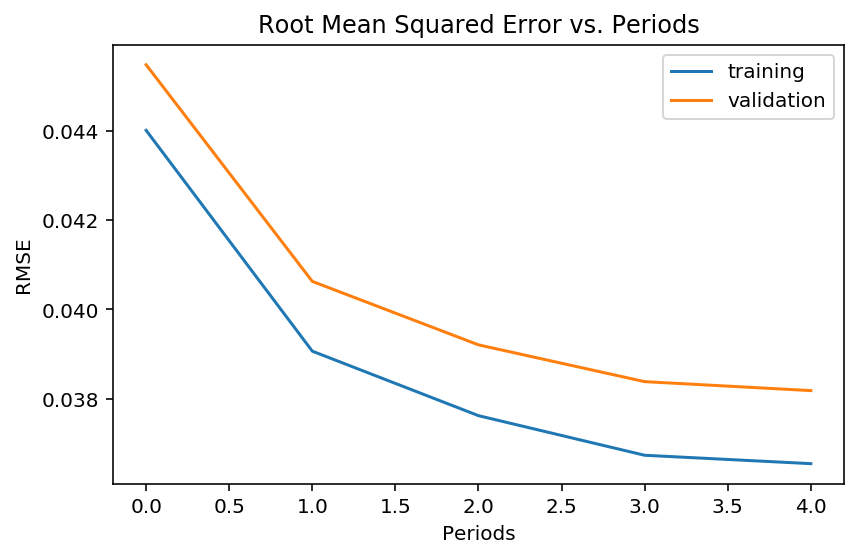

In [29]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)